In [17]:
import os
import glob
import numpy as np
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All imports successful
PyTorch version: 2.9.1+cu130
CUDA available: True


In [18]:
get_path = os.environ.get("UNI_PATH") # αυτό ειναι δικό μου, comment it out
DATA_PATH = Path(get_path).resolve()

# Dataset root
CITYSCAPES_ROOT = DATA_PATH / "Datasets" / "CityScapes5000"

# Image and label directories
IMAGES_DIR = CITYSCAPES_ROOT / "leftImg8bit"
LABELS_DIR = CITYSCAPES_ROOT / "gtFine"

print("=" * 60)
print("DATASET PATHS")

print("=" * 60)
print(f"Cityscapes root: {CITYSCAPES_ROOT}")
print(f"  Exists: {CITYSCAPES_ROOT.exists()}")

print(f"\nImages dir: {IMAGES_DIR}")
print(f"  Exists: {IMAGES_DIR.exists()}")

print(f"\nLabels dir: {LABELS_DIR}")
print(f"  Exists: {LABELS_DIR.exists()}")

DATASET PATHS
Cityscapes root: /mnt/c/Users/johnh/Desktop/simantik/METAPTYXIAKO assignments/Datasets/CityScapes5000
  Exists: True

Images dir: /mnt/c/Users/johnh/Desktop/simantik/METAPTYXIAKO assignments/Datasets/CityScapes5000/leftImg8bit
  Exists: True

Labels dir: /mnt/c/Users/johnh/Desktop/simantik/METAPTYXIAKO assignments/Datasets/CityScapes5000/gtFine
  Exists: True


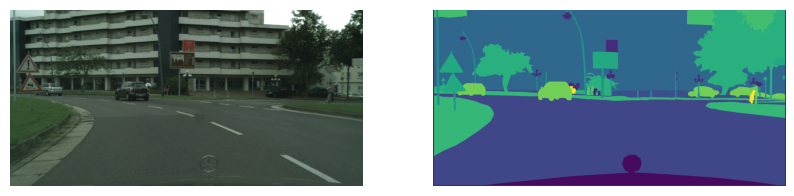

In [19]:
first_img_path = IMAGES_DIR / "train" / "aachen" / "aachen_000000_000019_leftImg8bit.png"
first_img_path_label = LABELS_DIR / "train" / "aachen" / "aachen_000000_000019_gtFine_labelIds.png"
first_img = Image.open(first_img_path)
first_img_label = Image.open(first_img_path_label)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(first_img)
ax[1].imshow(first_img_label)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [20]:
print("label shape: ", np.array(first_img_label).shape, "img shape: ", np.array(first_img).shape)

label shape:  (1024, 2048) img shape:  (1024, 2048, 3)


In [21]:
# inspect the label
first_img_label_array = np.array(first_img_label)
print("Number of classes in first image: ", len(np.unique(first_img_label_array)), "\nClasses: ", np.unique(first_img_label_array))


Number of classes in first image:  16 
Classes:  [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


In [22]:
# # List available splits
# print(f"\n" + "=" * 60)
# print("AVAILABLE SPLITS")
# print("=" * 60)
# for split in ['train', 'val', 'test']:
#     img_path = IMAGES_DIR / split
#     label_path = LABELS_DIR / split
#     if img_path.exists():
#         cities = [d.name for d in img_path.iterdir() if d.is_dir()]
#         print(f"{split}: {len(cities)} cities - {cities[:5]}{'...' if len(cities) > 5 else ''}")

In [23]:
# cityscapesscripts
# labels.py

# class mapping coding block
TRAIN_ID_MAP = {
    0: 255,  # unlabeled -> ignore
    1: 255,  # ego vehicle -> ignore
    2: 255,  # rectification border -> ignore
    3: 255,  # out of roi -> ignore
    4: 255,  # static -> ignore
    5: 255,  # dynamic -> ignore
    6: 255,  # ground -> ignore
    7: 0,    # road
    8: 1,    # sidewalk
    9: 255,  # parking -> ignore
    10: 255, # rail track -> ignore
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    14: 255, # guard rail -> ignore
    15: 255, # bridge -> ignore
    16: 255, # tunnel -> ignore
    17: 5,   # pole
    18: 255, # polegroup -> ignore
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    29: 255, # caravan -> ignore
    30: 255, # trailer -> ignore
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18,  # bicycle
    -1: 255, # license plate -> ignore
}

# Training class names (19 classes)
TRAIN_CLASSES = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
    'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
    'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'
]

NUM_CLASSES = 19  # Standard Cityscapes training classes
IGNORE_INDEX = 255  # Label to ignore during training


In [24]:
def count_images(split):
    """Count images in a split across all cities."""
    img_dir = IMAGES_DIR / split
    if not img_dir.exists():
        return 0, []
    
    images = []
    for city_dir in img_dir.iterdir():
        if city_dir.is_dir():
            city_images = list(city_dir.glob("*_leftImg8bit.png"))
            images.extend(city_images)
    return len(images), images


train_count, train_images = count_images('train')
val_count, val_images = count_images('val')
test_count, test_images = count_images('test')

print(f"Train: {train_count} images")
print(f"Val:   {val_count} images")
print(f"Test:  {test_count} images")
print(f"Total: {train_count + val_count + test_count} images")

Train: 2975 images
Val:   500 images
Test:  1525 images
Total: 5000 images


Image size: (2048, 1024)
Image mode: RGB

Label IDs size: (2048, 1024)
Label IDs mode: L

Label ID dtype: uint8
Label ID range: [0, 33]
Unique labels in this image: 16
Label values: [0, 1, 3, 4, 7, 8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33]


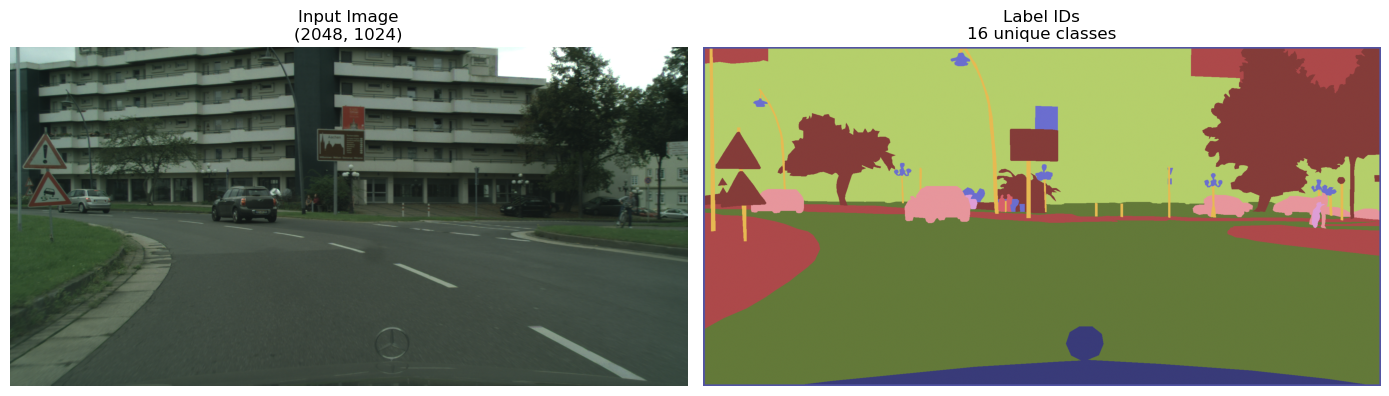

In [25]:
# opening first image and label
if train_images:
    sample_img_path = train_images[0]
    city = sample_img_path.parent.name
    base_name = sample_img_path.stem.replace('_leftImg8bit', '')
    
    label_ids_path = LABELS_DIR / 'train' / city / f"{base_name}_gtFine_labelIds.png"
    
    sample_img = Image.open(sample_img_path)
    label_ids = Image.open(label_ids_path)
    

    print(f"Image size: {sample_img.size}")
    print(f"Image mode: {sample_img.mode}")
    print(f"\nLabel IDs size: {label_ids.size}")
    print(f"Label IDs mode: {label_ids.mode}")
    
    # Analyze label values
    label_array = np.array(label_ids)
    unique_labels = np.unique(label_array)
    print(f"\nLabel ID dtype: {label_array.dtype}")
    print(f"Label ID range: [{label_array.min()}, {label_array.max()}]")
    print(f"Unique labels in this image: {len(unique_labels)}")
    print(f"Label values: {unique_labels.tolist()}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(sample_img)
    axes[0].set_title(f"Input Image\n{sample_img.size}")
    axes[0].axis('off')
    
    axes[1].imshow(label_array, cmap='tab20b')
    axes[1].set_title(f"Label IDs\n{len(unique_labels)} unique classes")
    axes[1].axis('off')

    
    plt.tight_layout()
    plt.show()

## PyTorch class

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader


class CityscapesDataset(Dataset):
    """
    PyTorch Dataset for official Cityscapes format.
    
    Loads images from leftImg8bit/ and labels from gtFine/*_labelIds.png
    """
    
    def __init__(self, root_dir, split='train', img_size=(512, 256), 
                 use_train_ids=True, transform=None):
        """
        Args:
            root_dir: Path to Cityscapes root (contains leftImg8bit/ and gtFine/)
            split: 'train', 'val', or 'test'
            img_size: Tuple (width, height) for resizing
            use_train_ids: If True, map 34 classes to 19 training classes
            transform: Optional transforms for augmentation
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.img_width, self.img_height = img_size
        self.use_train_ids = use_train_ids
        self.transform = transform
        
        # Collect all image paths
        self.images = []
        self.labels = []
        
        img_dir = self.root_dir / "leftImg8bit" / split
        label_dir = self.root_dir / "gtFine" / split
        
        for city_dir in sorted(img_dir.iterdir()):
            if city_dir.is_dir():
                city = city_dir.name
                for img_path in sorted(city_dir.glob("*_leftImg8bit.png")):
                    base_name = img_path.stem.replace('_leftImg8bit', '')
                    label_path = label_dir / city / f"{base_name}_gtFine_labelIds.png"
                    
                    if label_path.exists():
                        self.images.append(img_path)
                        self.labels.append(label_path)
        
        print(f"  Found {len(self.images)} image-label pairs in {split}")
    
    def __len__(self):
        return len(self.images)
    
    def _map_to_train_ids(self, label):
        """Map original label IDs (0-33) to training IDs (0-18, 255=ignore)"""
        label_copy = label.copy()
        for orig_id, train_id in TRAIN_ID_MAP.items():
            label_copy[label == orig_id] = train_id
        return label_copy
    
    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.images[idx]).convert('RGB')
        
        # Load label (as single channel)
        label = Image.open(self.labels[idx])
        
        # Resize
        img = img.resize((self.img_width, self.img_height), Image.BILINEAR)
        label = label.resize((self.img_width, self.img_height), Image.NEAREST)
        
        # Convert to numpy
        img_array = np.array(img)
        label_array = np.array(label, dtype=np.int64)
        
        # Map to training IDs if requested
        if self.use_train_ids:
            label_array = self._map_to_train_ids(label_array)
        
        # Apply transforms (if any)
        if self.transform:
            img_array = self.transform(img_array)
        
        # Convert to tensor
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.from_numpy(label_array).long()
        
        return img_tensor, label_tensor


### Ideas: 
1. function to measure resizing error + put metrics after resizing to put on final paper + a bit of bibliography research if needed for SSIM and other metrics
2. try inference on validation and test set in higher resolution

In [27]:
import os
num_cores = os.cpu_count()
print(f"CPU cores: {num_cores}")

CPU cores: 20


In [28]:
import platform


if platform.system() == 'Windows':
    print("Windows detected")
    NUM_WORKERS = 0  # or 1
else:
    print("Linux/Mac detected")
    NUM_WORKERS = 4  # Linux/Mac

Linux/Mac detected


In [29]:
# Configuration
IMG_SIZE = (512, 256)  # (width, height) - Cityscapes aspect ratio
BATCH_SIZE = 32    # big

# here we define the transforms. We also have to decide what transform to put for each set. ToTensor might be one of them.

train_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='train', img_size=IMG_SIZE, use_train_ids=True)
val_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='val', img_size=IMG_SIZE, use_train_ids=True)
test_dataset = CityscapesDataset(CITYSCAPES_ROOT, split='test', img_size=IMG_SIZE, use_train_ids=True)


# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

print("DATASET SUMMARY")
print("=" * 60)
print(f"Image size: {IMG_SIZE[0]} x {IMG_SIZE[1]} (W x H)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"\nTrain: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"\nVal:   {len(val_dataset)} images, {len(val_loader)} batches")
print(f"\nTest:  {len(test_dataset)} images, {len(test_loader)} batches")

  Found 2975 image-label pairs in train
  Found 500 image-label pairs in val
  Found 1525 image-label pairs in test
Using device: cuda

DATASET SUMMARY
Image size: 512 x 256 (W x H)
Batch size: 32
Number of classes: 19

Train: 2975 images, 93 batches

Val:   500 images, 16 batches

Test:  1525 images, 48 batches


In [30]:
# Quick test - compare 2 vs 4 workers
import time

def quick_test(num_workers):
    loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True)
    start = time.time()
    for i, _ in enumerate(loader):
        if i >= 10: break
    return time.time() - start

time_2 = quick_test(2)
time_4 = quick_test(4)
print(f"2 workers: {time_2:.2f}s")
print(f"4 workers: {time_4:.2f}s")
print(f"Speedup: {time_2/time_4:.2f}×")

2 workers: 20.00s
4 workers: 10.25s
Speedup: 1.95×


In [31]:
# na dw kai to permutation sto dataset, image tensor

In [32]:
# next i explore dataloaders or torch datasets, i re-create them with different transforms and i re-print.
# maybe i have to create a JointTransform class and apply before the dataset class
# check if augmentations are needed in train set, can use albumentations and i can run twice with a logger for results to compare
# 
